In this notebook the "MSFT" stock data is loaded and feature engineering is performed adding parameters such as (RSI, Standart moving average (SMA), Closing price ratios, trend indicators). Subsequently, the dataframe is reformed to contain parameters of several previous days (sliding window). The attempt to predict following day price change indicator using Random Forest classifier and Neural network is made. Classifier principal metrics (including RoC curve) are provided. Forward Feature Selection is used for the attempt to improve the results. As a following step, procedure is repeated, but this time the attempt is amde to predict the following day stock closing price and then converting it into price change indicator as a data post processing step (using Random Forest Regressor and Neural Network). Results are visualised, metrics calculated and compared. As a final note Principal Component Analysis is performed and the same predictions attempted (Closing price indicator and Closing price).  

# Get the data and process it

In [89]:
import pandas as pd
import numpy as np
import yfinance as yf
#import mpld3
#mpld3.enable_notebook()
 
msft = yf.Ticker("MSFT")

# get historical market data
data = msft.history(period="max")

data = data.loc["2010-01-01":].copy()

In [90]:
hist = data.copy(deep=True)
hist["Tomorrow"] = hist["Close"].shift(-1)
hist["Target"] = (hist["Tomorrow"] > hist["Close"]).astype(int) 
#1 if followind day price incresed, 0 otherwise

horizons = [2,5,60,250,1000]

for horizon in horizons:
    rolling_averages = hist.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    hist[ratio_column] = hist["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    hist[trend_column] = hist.shift(1).rolling(horizon).sum()["Target"]
    
hist['SMA10'] = hist['Close'].rolling(10).mean()
hist['Dec_SMA10'] = (hist.SMA10 < hist.SMA10.shift(10)).astype(int);

hist['SMA30'] = hist['Close'].rolling(30).mean()
hist['Dec_SMA30'] = (hist.SMA30 < hist.SMA30.shift(30)).astype(int);

hist['SMA100'] = hist['Close'].rolling(100).mean()
hist['Dec_SMA100'] = (hist.SMA100 < hist.SMA100.shift(100)).astype(int);


In [91]:
try:
    del hist['Dividends']
    del hist['Stock Splits']
except:
    pass

In [92]:
hist.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,...,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,SMA10,Dec_SMA10,SMA30,Dec_SMA30,SMA100,Dec_SMA100
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04 00:00:00-05:00,23.321028,23.686609,23.298179,23.572365,38409100,23.579981,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0
2010-01-05 00:00:00-05:00,23.496203,23.686610,23.336260,23.579981,49749600,23.435282,0,1.000162,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0
2010-01-06 00:00:00-05:00,23.519060,23.671386,23.244875,23.435282,58182400,23.191557,0,0.996922,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0
2010-01-07 00:00:00-05:00,23.328649,23.381964,22.993534,23.191557,50559700,23.351496,1,0.994773,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0
2010-01-08 00:00:00-05:00,23.062078,23.519053,23.031612,23.351496,51197400,23.054464,0,1.003436,1.0,0.996814,...,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0


## Lets add RSI (Relative Strength Index) as a feature

In [93]:
from typing import Callable
# Define function to calculate the RSI
def calc_rsi(over: pd.Series, fn_roll: Callable) -> pd.Series:
    # Get the difference in price from previous step
    delta = over.diff()
    # Get rid of the first row, which is NaN since it did not have a previous row to calculate the differences
    delta = delta[1:] 

    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.clip(lower=0), delta.clip(upper=0).abs()

    roll_up, roll_down = fn_roll(up), fn_roll(down)
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    # Avoid division-by-zero if `roll_down` is zero
    # This prevents inf and/or nan values.
    rsi[:] = np.select([roll_down == 0, roll_up == 0, True], [100, 0, rsi])
    rsi.name = 'rsi'

    # Assert range
    valid_rsi = rsi[length - 1:]
    assert ((0 <= valid_rsi) & (valid_rsi <= 100)).all()
    # Note: rsi[:length - 1] is excluded from above assertion because it is NaN for SMA.

    return rsi

In [94]:
# Window length for moving average
lengths = [10,30]
# Calculate RSI using MA of choice
for length in lengths:
    # Reminder: Provide ≥ `1 + length` extra data points!
    hist['rsi_ema_'+str(length)] = calc_rsi(hist['Close'], lambda s: s.ewm(span=length).mean())
    hist['rsi_sma_'+str(length)] = calc_rsi(hist['Close'], lambda s: s.rolling(length).mean())
    hist['rsi_rma_'+str(length)] = calc_rsi(hist['Close'], lambda s: s.ewm(alpha=1 / length).mean())  

In [95]:
hist = hist.dropna()
hist.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,...,SMA30,Dec_SMA30,SMA100,Dec_SMA100,rsi_ema_10,rsi_sma_10,rsi_rma_10,rsi_ema_30,rsi_sma_30,rsi_rma_30
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-23 00:00:00-05:00,31.124770,31.192413,30.904925,30.964113,25128700,31.353071,1,0.997548,1.0,1.001806,...,31.681078,0,29.176987,0,40.046599,21.832881,42.347386,46.602324,45.932422,51.995364
2013-12-24 00:00:00-05:00,31.048672,31.429168,30.981026,31.353071,14243000,31.657471,1,1.006242,1.0,1.011291,...,31.674678,0,29.224774,0,53.790279,35.574243,49.415350,50.785524,48.971181,53.932988
2013-12-26 00:00:00-05:00,31.454540,31.699751,31.429171,31.657471,17612800,31.530630,0,1.004831,2.0,1.016342,...,31.684859,0,29.277187,0,62.100524,47.521910,54.288396,53.812543,51.617314,55.390715
2013-12-27 00:00:00-05:00,31.775841,31.809661,31.429162,31.530630,14563000,31.530630,0,0.997993,1.0,1.006586,...,31.668433,0,29.329332,0,56.890005,51.096854,51.970415,52.377564,47.230833,54.645336
2013-12-30 00:00:00-05:00,31.471442,31.606730,31.200865,31.530630,16290500,31.632107,1,1.000000,0.0,1.003931,...,31.655923,0,29.377478,0,56.890005,61.278223,51.970415,52.377564,47.862895,54.645336


Lets plot the data

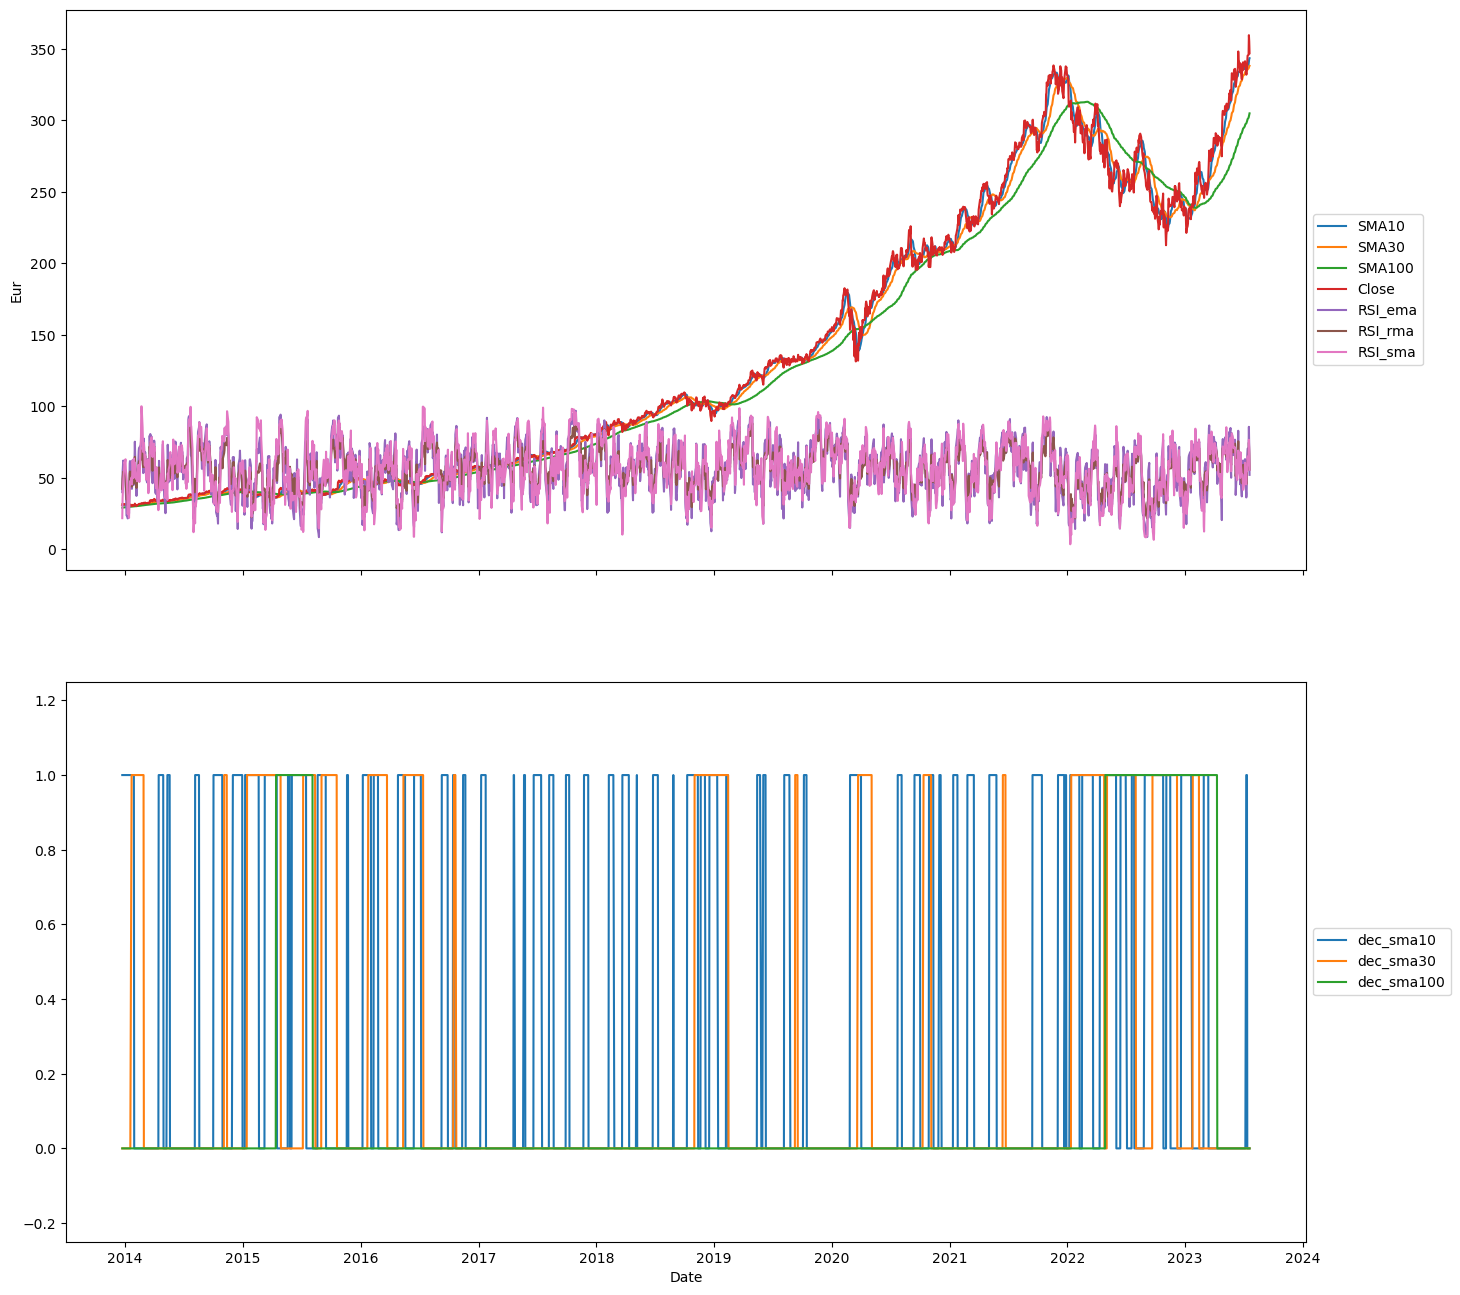

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline
hist.dropna(inplace=True)

fig, ax = plt.subplots(2,1, sharex= True,figsize=(16,16))
ax[0].plot(hist['SMA10'], label = 'SMA10')
ax[0].plot(hist['SMA30'], label = 'SMA30')
ax[0].plot(hist['SMA100'], label = 'SMA100')
ax[0].plot(hist['Close'], label = 'Close')

ax[0].plot(hist['rsi_ema_10'], label = 'RSI_ema')
ax[0].plot(hist['rsi_rma_10'], label = 'RSI_rma')
ax[0].plot(hist['rsi_sma_10'], label = 'RSI_sma')

ax[1].plot(hist['Dec_SMA10'], label = 'dec_sma10')
ax[1].plot(hist['Dec_SMA30'], label = 'dec_sma30')
ax[1].plot(hist['Dec_SMA100'], label = 'dec_sma100')

ax[0].set_ylabel('Eur')
ax[1].set_xlabel('Date')
# Put a legend to the right of the current axis
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[1].set_ylim([-0.25,1.25])

plt.show()

# Define sliding window to consider number of days history in predictions

In [97]:
def SlidingWindow(in_df: pd.DataFrame, window_size: int, period_shift = 1):
    """ We put <window size> amount of data into singular row
    in_df - input DataFrame
    window_size - number of days of history
    period_shift - number of days between successive data samples
    
    """
    #window_size determines how many data points in the past we are interested
    column_names = [(x+'_'+str(y+1)) for y in range(0,window_size) for x in in_df.columns]
    column_names.extend(['next_day_Close', 'next_day_Change'])
    df = pd.DataFrame(columns = column_names)
    for row_i in range(0,in_df.shape[0]-window_size+1, period_shift):
        window_data = []
        for i in range(window_size):
            window_data.extend(in_df.iloc[row_i+i].values)
        try:    
            window_data.append(in_df.iloc[row_i+i+1]['Close'])
            window_data.append(in_df.iloc[row_i+i+1]['Target'])
        except IndexError:
            window_data.append(None)
            window_data.append(None)

        df.loc[in_df.index[row_i]] = window_data
    return df

In [98]:
df = hist.copy(deep=True)
principal_predictors = df.columns
window_width = 5 #how many previous data points will be used for prediction
df = SlidingWindow(df, window_width)
df.dropna(inplace=True)

In [99]:
print(principal_predictors)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Tomorrow', 'Target',
       'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
       'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250',
       'Close_Ratio_1000', 'Trend_1000', 'SMA10', 'Dec_SMA10', 'SMA30',
       'Dec_SMA30', 'SMA100', 'Dec_SMA100', 'rsi_ema_10', 'rsi_sma_10',
       'rsi_rma_10', 'rsi_ema_30', 'rsi_sma_30', 'rsi_rma_30'],
      dtype='object')


# Attempt predict if next day closing price will be higher

## Random Forest classifier

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [101]:
def predict_prob(train, test, predictors, target, model, threshold = 0.5):
    model.fit(train[predictors], train[target])
    preds = model.predict_proba(test[predictors])[:,1] 
    preds[preds >=threshold] = 1
    preds[preds <threshold] = 0
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test[target], preds], axis = 1)
    return combined

Lets try to use Forward Feature Selection. Features are introduced at each iteration to enhance the model's functionality. The functionalities are maintained if performance is increased. Features that do not enhance the outcomes are removed.

In [102]:
#Lets see if we can predict whether tomorrow closing price will be higher (1) or lower(0) than previous day
from sklearn.metrics import precision_score

target = 'next_day_Change'
pred_score = 0
used_predictors = []

q80 = int(df.shape[0]*0.8) 
train = df.iloc[:q80]
test = df.iloc[q80:]

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

for predictor in principal_predictors:
    #we use all window width predictors (same as history count)
    window_predictors = [predictor+'_'+str(i+1) for i in range(window_width)]
    temp_predictors = used_predictors + window_predictors
    model_out = predict_prob(train, test, temp_predictors, target, model)
    
    current_score = precision_score(model_out["next_day_Change"], model_out["Predictions"])
    if current_score > pred_score:
        used_predictors = used_predictors + window_predictors
        pred_score = current_score

print(f'Precision score: {pred_score} \nwith predictors: {used_predictors}')

Precision score: 0.5502008032128514 
with predictors: ['Open_1', 'Open_2', 'Open_3', 'Open_4', 'Open_5', 'High_1', 'High_2', 'High_3', 'High_4', 'High_5', 'Low_1', 'Low_2', 'Low_3', 'Low_4', 'Low_5', 'Close_Ratio_2_1', 'Close_Ratio_2_2', 'Close_Ratio_2_3', 'Close_Ratio_2_4', 'Close_Ratio_2_5', 'Trend_2_1', 'Trend_2_2', 'Trend_2_3', 'Trend_2_4', 'Trend_2_5', 'Close_Ratio_5_1', 'Close_Ratio_5_2', 'Close_Ratio_5_3', 'Close_Ratio_5_4', 'Close_Ratio_5_5', 'Trend_5_1', 'Trend_5_2', 'Trend_5_3', 'Trend_5_4', 'Trend_5_5']


So the prediction at the best score:

In [103]:
model_out = predict_prob(train, test, used_predictors, target, model)

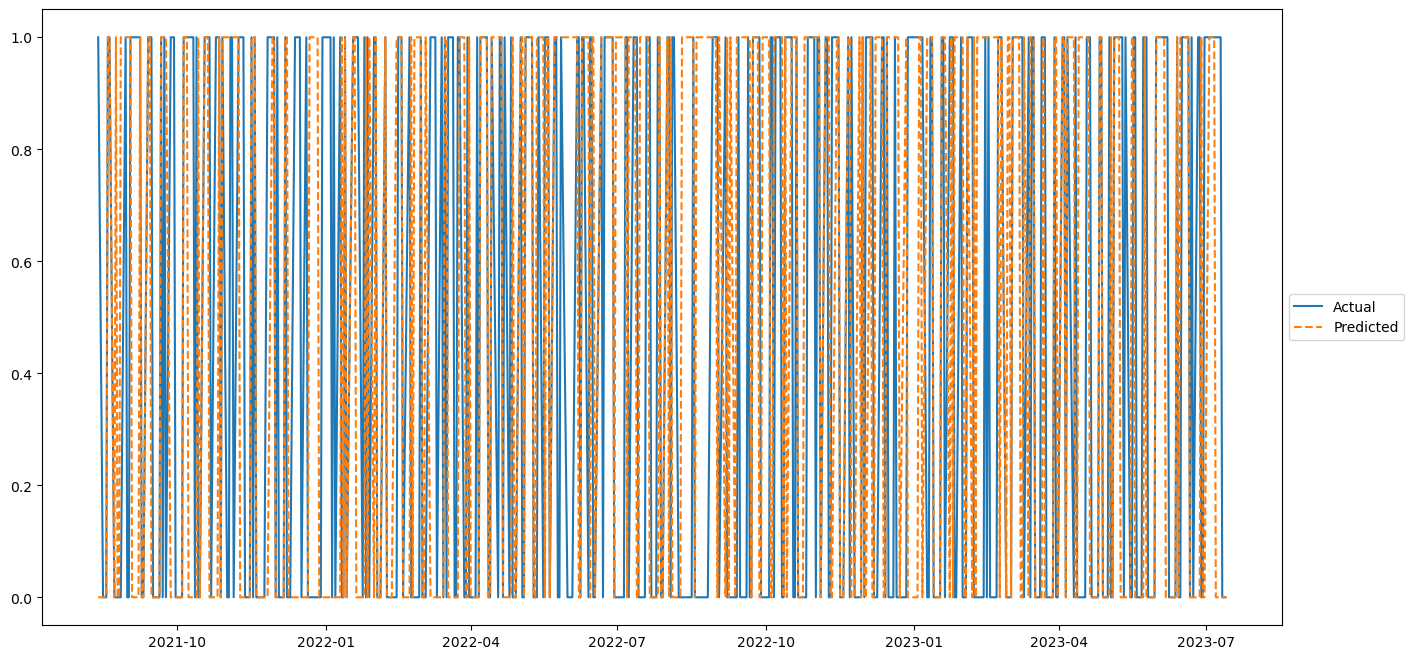

In [104]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(model_out[target], label='Actual')
ax.plot(model_out['Predictions'], linestyle ='dashed',label='Predicted')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [105]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(model_out["next_day_Change"], model_out["Predictions"])
print(cf_matrix)

[[133 112]
 [ 99 137]]


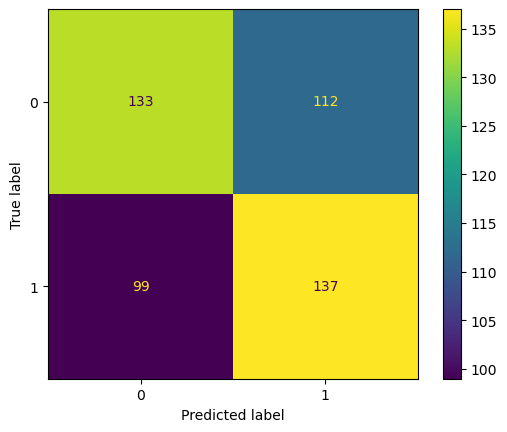

In [106]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot()
plt.show()

In [107]:
model_out[target].value_counts() / model_out.shape[0]

0.0    0.509356
1.0    0.490644
Name: next_day_Change, dtype: float64

In [108]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
recall = recall_score(model_out["next_day_Change"], model_out["Predictions"])
precision = precision_score(model_out["next_day_Change"], model_out["Predictions"])
accuracy = accuracy_score(model_out["next_day_Change"], model_out["Predictions"])
f1 = f1_score(model_out["next_day_Change"], model_out["Predictions"])
print(f'Recall: {recall} \nPrecision: {precision} \nAccuracy: {accuracy} \nF1: {f1}')

Recall: 0.5805084745762712 
Precision: 0.5502008032128514 
Accuracy: 0.5613305613305614 
F1: 0.5649484536082473


Recall: how many actually possitive cases were correctly identified TP/(TP+FN)  
Precision: how many positive predictions were REALLY possitive TP/(TP+FP)  
Accuracy: number of correct prediction/ number of all predictions (TP+TN)/all  

High recall: more likely to mark negative results as possitive  
                when price was going down we indicated that it will go up  
High precision: more likely to mark possitive result as negative  

## Lets try Neural Network to predict price change indicator

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf

def compile_nn_model(features):
    nr_inputs = len(features)
    model = Sequential([layers.Input((nr_inputs, 1)),
                        layers.LSTM(64), 
                        layers.Dense(32, activation='relu'),
                        layers.Dense(32, activation='relu'),
                        layers.Dense(1)])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=100,
        decay_rate=0.9)

    optimiser = Adam(learning_rate = lr_schedule)

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
    #we use Binary as loss function,because we are working with 2 classes
                    optimizer = optimiser,#tf.keras.optimizers.SGD(learning_rate=0.1), #lr 0.01 for normal df and 20 epochs
    #SGD stands for Stochastic Gradient Descent
                    metrics = ['accuracy'])
    return model

lets normalise the data (mean normalisation)

In [110]:
predictors = [(x+'_'+str(y+1)) for y in range(0,window_width) for x in principal_predictors]
#use z-score normalization
normalized_df=(df[predictors]-df[predictors].mean())/df[predictors].std()
normalized_df['next_day_Change'] = df['next_day_Change'].copy(deep=True)
normalized_df['next_day_Close'] = df['next_day_Close'].copy(deep=True)

In [111]:
normalized_df[target].value_counts()

1.0    1273
0.0    1131
Name: next_day_Change, dtype: int64

In [112]:
#Lets see if we can predict whether tomorrow closing price will be higher (1) or lower(0) than previous day
from sklearn.metrics import precision_score
from keras.callbacks import EarlyStopping

target = 'next_day_Change'
pred_score = 0

in_df = normalized_df #df #normalised df always predicts same value

q80 = int(in_df.shape[0]*0.8) 
q90 = int(in_df.shape[0]*0.9) 
train = in_df.iloc[:q80]
val = in_df.iloc[q80:q90]
test = in_df.iloc[q90:]

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta = 0.05)


predictors = [(x+'_'+str(y+1)) for y in range(0,window_width) for x in principal_predictors]

model = compile_nn_model(predictors)
history = model.fit(np.array(train[predictors]), np.array(train[target])
        ,validation_data=(val[predictors], val[target])
        ,batch_size= 32
        ,epochs=50
        ,callbacks = [es]
         )

Epoch 1/50
61/61 [==============================] - 7s 81ms/step - loss: 1.2030 - accuracy: 0.4852 - val_loss: 0.7101 - val_accuracy: 0.5083
Epoch 2/50
61/61 [==============================] - 4s 70ms/step - loss: 0.6986 - accuracy: 0.5211 - val_loss: 0.7060 - val_accuracy: 0.5042
Epoch 3/50
61/61 [==============================] - 4s 65ms/step - loss: 0.6947 - accuracy: 0.5153 - val_loss: 0.6900 - val_accuracy: 0.5167
Epoch 4/50
61/61 [==============================] - 4s 68ms/step - loss: 0.6975 - accuracy: 0.5070 - val_loss: 0.6948 - val_accuracy: 0.5042
Epoch 5/50
61/61 [==============================] - 4s 65ms/step - loss: 0.6955 - accuracy: 0.5205 - val_loss: 0.6961 - val_accuracy: 0.5042
Epoch 6/50
61/61 [==============================] - 4s 67ms/step - loss: 0.6929 - accuracy: 0.5278 - val_loss: 0.7012 - val_accuracy: 0.5042
Epoch 6: early stopping


In [113]:
train_predictions = model.predict(train[predictors]).flatten()

61/61 [==============================] - 2s 26ms/step


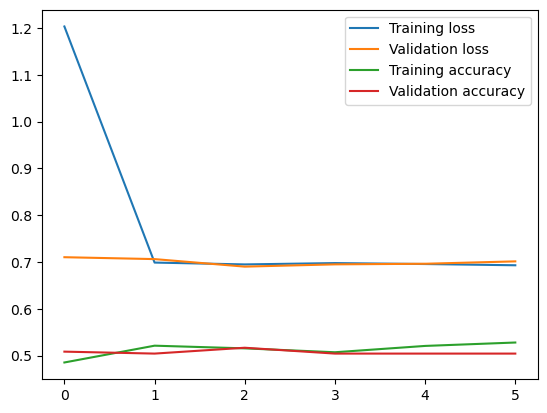

In [114]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training loss','Validation loss','Training accuracy','Validation accuracy'])

1923
1923


array([0.5400165 , 0.5398426 , 0.54065526, ..., 0.5433576 , 0.5595379 ,
       0.5745094 ], dtype=float32)

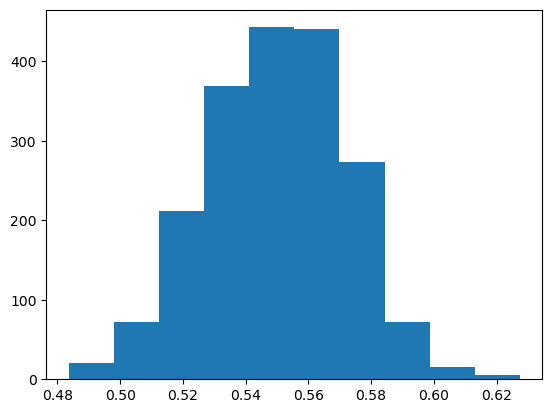

In [115]:
print(len(np.array(train[target])))
print(len(train_predictions))
plt.hist(train_predictions)
train_predictions

In [116]:
import copy
thrsh = 0.5
train_predictions_round = copy.deepcopy(train_predictions)
train_predictions_round[train_predictions_round >=thrsh] = 1
train_predictions_round[train_predictions_round <thrsh] = 0
preds = pd.Series(train_predictions_round, index = train[target].index,name="Predictions")
combined = pd.concat([train[target], preds], axis=1)
combined.head()

,next_day_Change,Predictions
2013-12-23 00:00:00-05:00,0.0,1.0
2013-12-24 00:00:00-05:00,0.0,1.0
2013-12-26 00:00:00-05:00,0.0,1.0
2013-12-27 00:00:00-05:00,1.0,1.0
2013-12-30 00:00:00-05:00,0.0,1.0


<Axes: >

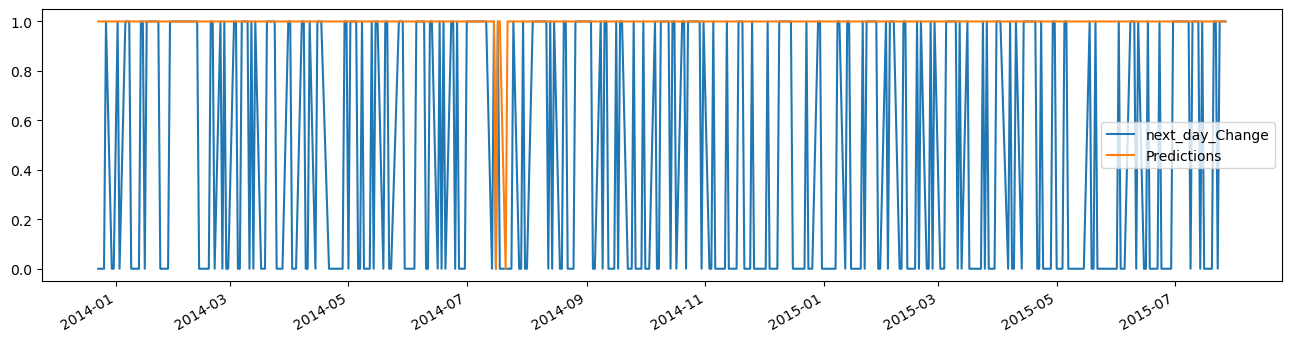

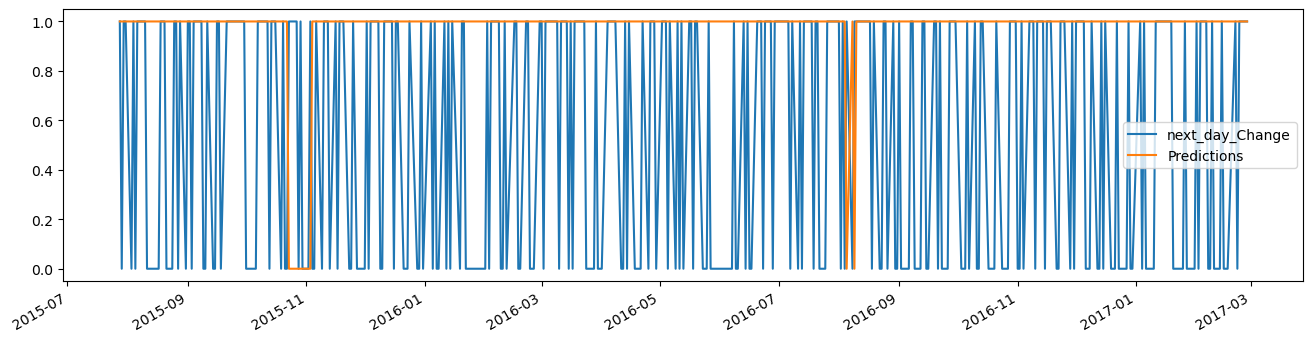

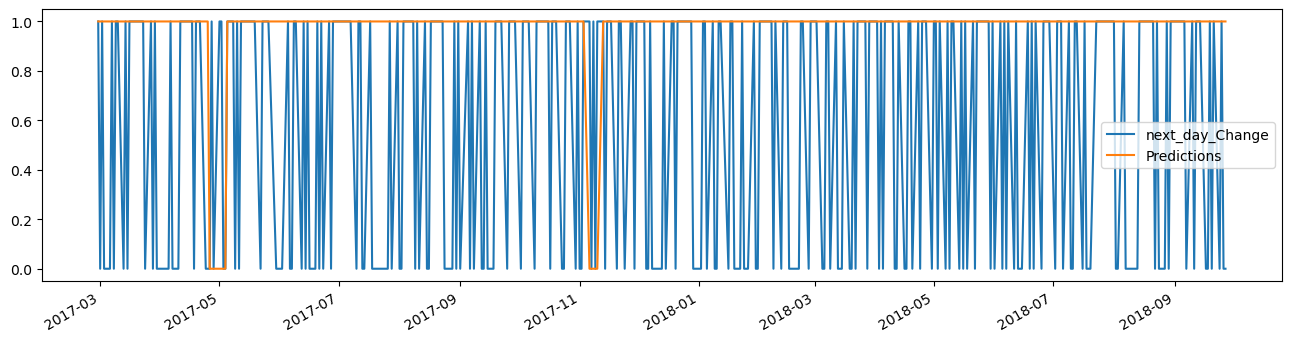

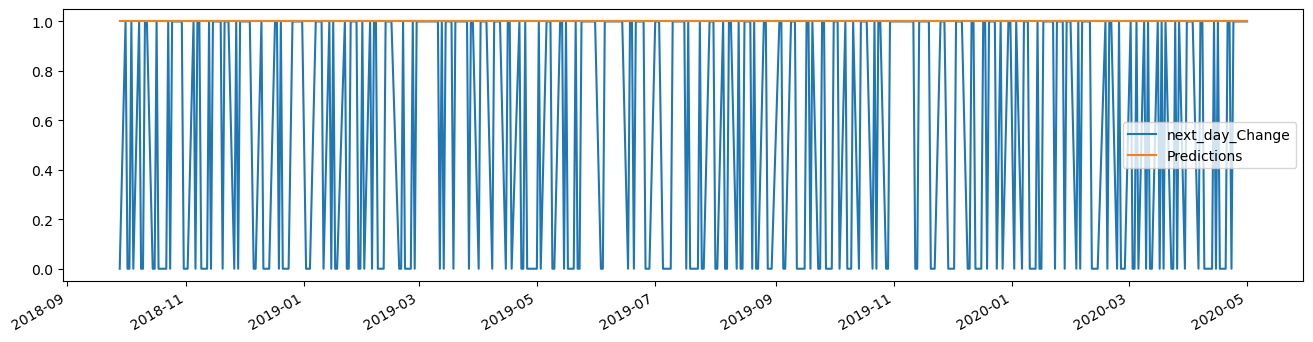

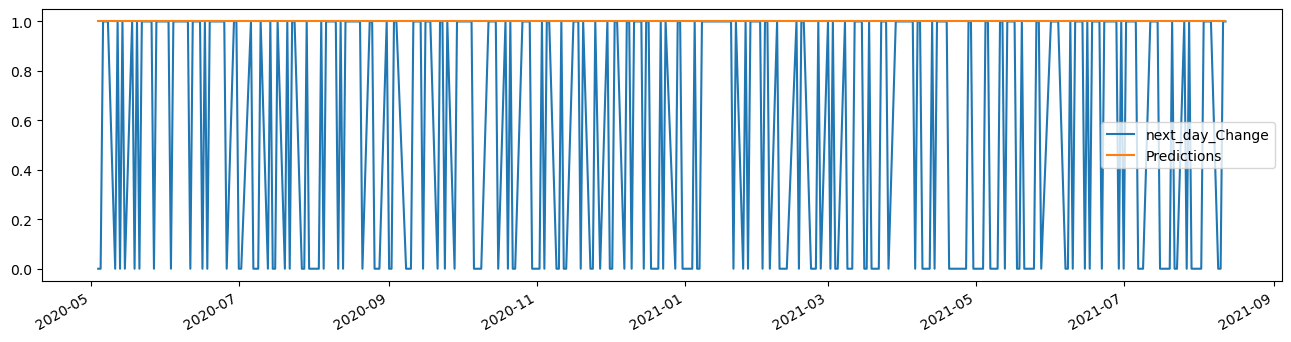

In [117]:
combined.iloc[:400].plot(y=[target,'Predictions'],figsize=(16,4))
combined.iloc[400:800].plot(y=[target,'Predictions'],figsize=(16,4))
combined.iloc[800:1200].plot(y=[target,'Predictions'],figsize=(16,4))
combined.iloc[1200:1600].plot(y=[target,'Predictions'],figsize=(16,4))
combined.iloc[1600:].plot(y=[target,'Predictions'],figsize=(16,4))


In [118]:
precision_score(combined[target], combined['Predictions'])

0.5392311743022643

In [119]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
recall = recall_score(np.array(train[target]), train_predictions_round)
precision = precision_score(np.array(train[target]), train_predictions_round)
accuracy = accuracy_score(np.array(train[target]), train_predictions_round)
f1 = f1_score(np.array(train[target]), train_predictions_round)
print(f'Recall: {recall} \nPrecision: {precision} \nAccuracy: {accuracy} \nF1: {f1}')

Recall: 0.9874638379942141 
Precision: 0.5392311743022643 
Accuracy: 0.5382215288611545 
F1: 0.6975476839237057


Recall: how many actually possitive cases were correctly identified TP/(TP+FN)  
Precision: how many positive predictions were REALLY possitive TP/(TP+FP)  
Accuracy: number of correct prediction/ number of all predictions (TP+TN)/all  

High recall: more likely to mark negative results as possitive  
                when price was going down we indicated that it will go up  
High precision: more likely to mark possitive result as negative  

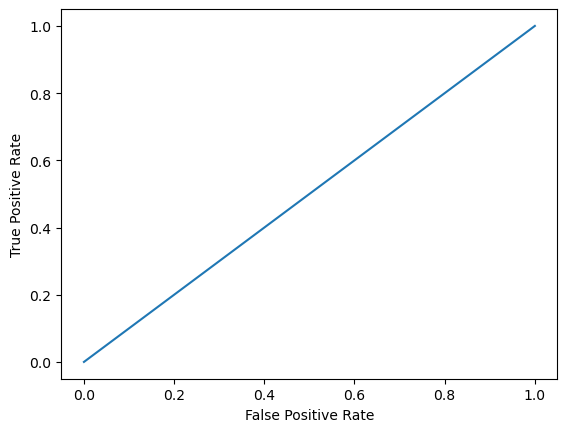

In [120]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(np.array(train[target]),  train_predictions_round)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [121]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(np.array(train[target]), train_predictions_round)
print(cf_matrix)

[[  11  875]
 [  13 1024]]


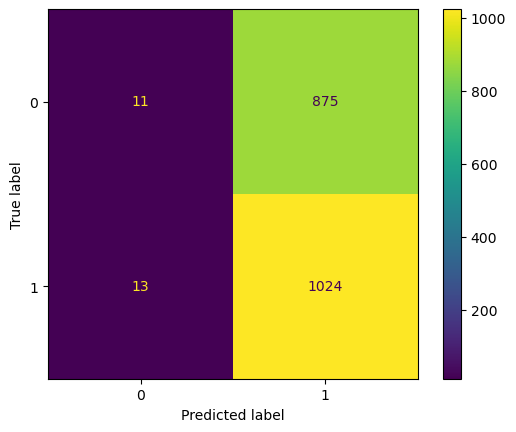

In [122]:
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
disp.plot();

## Lets try with less features

Attempt to use the same features detected during random forest classifier stage using Forward feature selection

In [123]:
used_predictors 

['Open_1',
 'Open_2',
 'Open_3',
 'Open_4',
 'Open_5',
 'High_1',
 'High_2',
 'High_3',
 'High_4',
 'High_5',
 'Low_1',
 'Low_2',
 'Low_3',
 'Low_4',
 'Low_5',
 'Close_Ratio_2_1',
 'Close_Ratio_2_2',
 'Close_Ratio_2_3',
 'Close_Ratio_2_4',
 'Close_Ratio_2_5',
 'Trend_2_1',
 'Trend_2_2',
 'Trend_2_3',
 'Trend_2_4',
 'Trend_2_5',
 'Close_Ratio_5_1',
 'Close_Ratio_5_2',
 'Close_Ratio_5_3',
 'Close_Ratio_5_4',
 'Close_Ratio_5_5',
 'Trend_5_1',
 'Trend_5_2',
 'Trend_5_3',
 'Trend_5_4',
 'Trend_5_5']

In [124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf

def compile_nn_model(features):
    nr_inputs = len(predictors)
    model = Sequential([layers.Input((nr_inputs, 1)),
                        layers.LSTM(64), 
                        layers.Dense(32, activation='relu'),
                        #layers.Dense(32, activation='relu'),
                        layers.Dense(1)])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-4,
        decay_steps=100,
        decay_rate=0.9)

    optimiser = Adam(learning_rate = lr_schedule)

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
    #we use Binary as loss function,because we are working with 2 classes
                    optimizer = optimiser,#tf.keras.optimizers.SGD(learning_rate=0.1), #lr 0.01 for normal df and 20 epochs
    #SGD stands for Stochastic Gradient Descent
                    metrics = ['accuracy'])
    return model

In [125]:
#Lets see if we can predict whether tomorrow closing price will be higher (1) or lower(0) than previous day
from sklearn.metrics import precision_score
from keras.callbacks import EarlyStopping

target = 'next_day_Change'

in_df = normalized_df #df #normalised df always predicts same value

q80 = int(in_df.shape[0]*0.8) 
q90 = int(in_df.shape[0]*0.9) 
train = in_df.iloc[:q80]
val = in_df.iloc[q80:q90]
test = in_df.iloc[q90:]

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta = 0.05)

predictors = used_predictors

model = compile_nn_model(predictors)
history = model.fit(np.array(train[predictors]), np.array(train[target])
        ,validation_data=(val[predictors], val[target])
        ,batch_size= 32
        ,epochs=50
        ,callbacks = [es]
         )

Epoch 1/50
61/61 [==============================] - 4s 34ms/step - loss: 4.3908 - accuracy: 0.4607 - val_loss: 1.8568 - val_accuracy: 0.4958
Epoch 2/50
61/61 [==============================] - 1s 20ms/step - loss: 1.6753 - accuracy: 0.4607 - val_loss: 1.5442 - val_accuracy: 0.4958
Epoch 3/50
61/61 [==============================] - 1s 20ms/step - loss: 1.5282 - accuracy: 0.4607 - val_loss: 1.4062 - val_accuracy: 0.4958
Epoch 4/50
61/61 [==============================] - 1s 21ms/step - loss: 1.4407 - accuracy: 0.4607 - val_loss: 1.3283 - val_accuracy: 0.4958
Epoch 5/50
61/61 [==============================] - 1s 21ms/step - loss: 1.3763 - accuracy: 0.4607 - val_loss: 1.2709 - val_accuracy: 0.4958
Epoch 6/50
61/61 [==============================] - 1s 20ms/step - loss: 1.3243 - accuracy: 0.4607 - val_loss: 1.2228 - val_accuracy: 0.4958
Epoch 7/50
61/61 [==============================] - 1s 20ms/step - loss: 1.2797 - accuracy: 0.4607 - val_loss: 1.1821 - val_accuracy: 0.4958
Epoch 8/50
61

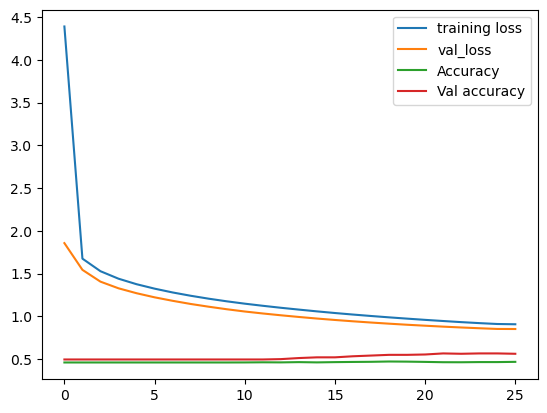

In [126]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend()

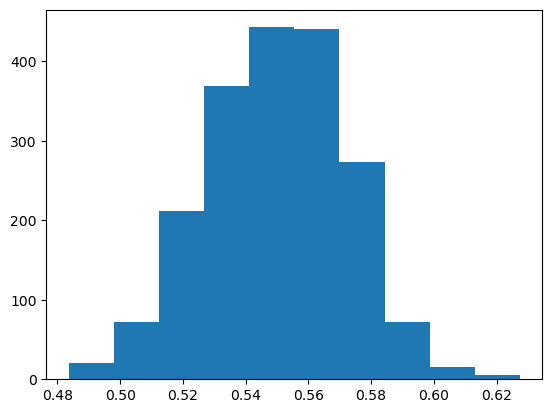

In [127]:
plt.hist(train_predictions);

In [128]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
recall = recall_score(np.array(train[target]), train_predictions_round)
precision = precision_score(np.array(train[target]), train_predictions_round)
accuracy = accuracy_score(np.array(train[target]), train_predictions_round)
f1 = f1_score(np.array(train[target]), train_predictions_round)
print(f'Recall: {recall} \nPrecision: {precision} \nAccuracy: {accuracy} \nF1: {f1}')

Recall: 0.9874638379942141 
Precision: 0.5392311743022643 
Accuracy: 0.5382215288611545 
F1: 0.6975476839237057


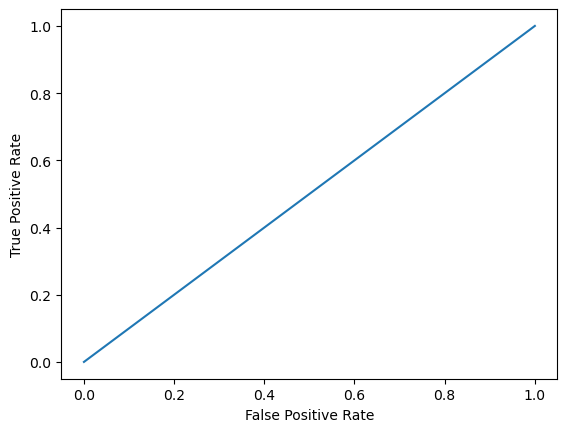

In [129]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(np.array(train[target]),  train_predictions_round)
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

This has improved nothing.

# Closing price prediction

Try to predict actual closing price instead of price change and then deduce the price change (up or down)

## First with simple RF

In [130]:
def predict(train, test, predictors, target, model, threshold = 0.5):
    model.fit(train[predictors], train[target])
    preds = model.predict(test[predictors]) 
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test[target], preds], axis = 1)
    return combined

In [131]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

target = 'next_day_Close'
rmse_score = 99999
rmse_scores = []
used_predictors = []

in_df = df

q80 = int(in_df.shape[0]*0.8) 
train = in_df.iloc[:q80]
test = in_df.iloc[q80:]

model = RandomForestRegressor(n_estimators=100, min_samples_split=100, random_state=1)

for predictor in principal_predictors:
    #we use all window width predictors (same as history count)
    window_predictors = [predictor+'_'+str(i+1) for i in range(window_width)]
    temp_predictors = used_predictors + window_predictors
    model_out = predict(train, test, temp_predictors, target, model)
    
    current_rmse = mean_squared_error(model_out[target], model_out["Predictions"])
    rmse_scores.append(current_rmse)
    if current_rmse < rmse_score:
        used_predictors = used_predictors + window_predictors
        rmse_score = current_rmse

print(f'RMSE score: {rmse_score} \nwith predictors: {used_predictors}')

RMSE score: 1471.9941228444275 
with predictors: ['Open_1', 'Open_2', 'Open_3', 'Open_4', 'Open_5', 'High_1', 'High_2', 'High_3', 'High_4', 'High_5', 'Low_1', 'Low_2', 'Low_3', 'Low_4', 'Low_5', 'Close_1', 'Close_2', 'Close_3', 'Close_4', 'Close_5', 'Volume_1', 'Volume_2', 'Volume_3', 'Volume_4', 'Volume_5', 'Tomorrow_1', 'Tomorrow_2', 'Tomorrow_3', 'Tomorrow_4', 'Tomorrow_5', 'Target_1', 'Target_2', 'Target_3', 'Target_4', 'Target_5', 'Dec_SMA100_1', 'Dec_SMA100_2', 'Dec_SMA100_3', 'Dec_SMA100_4', 'Dec_SMA100_5']


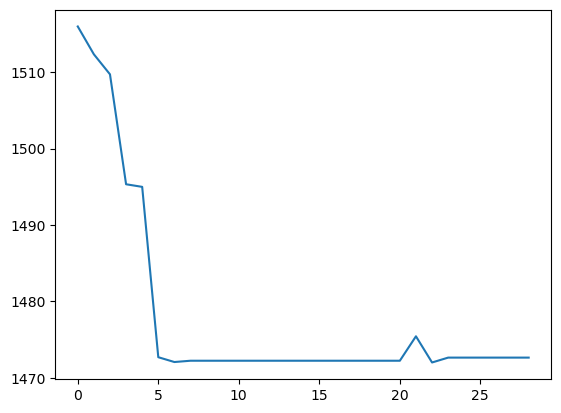

In [132]:
plt.plot(rmse_scores)

In [133]:
model_out = predict(train, test, used_predictors, target, model)

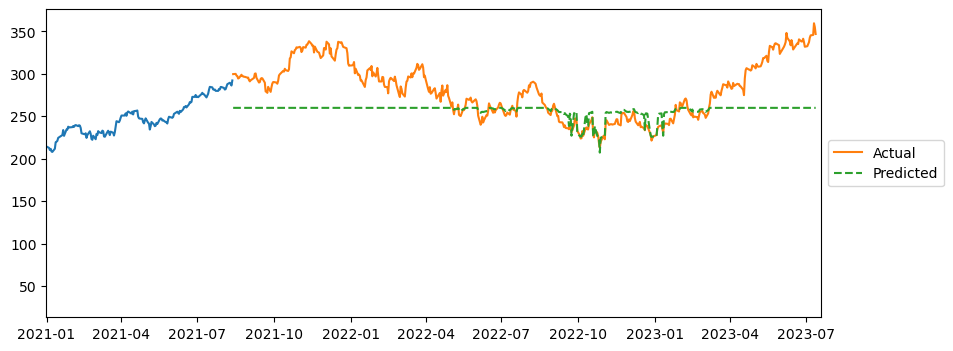

In [134]:
import datetime
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(train[target])
ax.plot(model_out[target], label='Actual')
ax.plot(model_out['Predictions'], linestyle ='dashed',label='Predicted')
ax.set_xlim([datetime.date(2021, 1, 1), datetime.date(2023, 7, 20)])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Results are uninspiring

## With LSTM (Long Short Term Memory) NN

In [135]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf


def compile_nn(predictors):
    nr_inputs = len(predictors)

    model = Sequential([layers.Input((nr_inputs, 1)),
                        layers.LSTM(64), #LSTM
                        layers.Dense(32, activation='relu'),
                        layers.Dense(32, activation='relu'),
                        layers.Dense(1)])

    model.compile(loss = 'mse',
                    optimizer = Adam(learning_rate=0.001), 
                    metrics = ['mean_absolute_error'])
    return model

In [136]:
from sklearn.metrics import precision_score

predictors = [(x+'_'+str(y+1)) for y in range(0,window_width) for x in principal_predictors]

target = 'next_day_Close'
pred_score = 0
used_predictors = []

in_df = df #normalized_df

q80 = int(in_df.shape[0]*0.8)
q90 = int(in_df.shape[0]*0.9) 
train = in_df.iloc[:q80]
val = in_df.iloc[q80:q90]
test = in_df.iloc[q90:]

es = EarlyStopping(monitor='mean_absolute_error', mode='min', verbose=1, patience=5, min_delta = 2)

model = compile_nn(predictors)
history = model.fit(np.array(train[predictors]), np.array(train[target])
                    ,validation_data=(val[predictors], val[target])
                    ,epochs=50
                    ,callbacks = [es]
                   )

Epoch 1/50
61/61 [==============================] - 7s 75ms/step - loss: 13326.9131 - mean_absolute_error: 93.7243 - val_loss: 71944.5234 - val_mean_absolute_error: 267.0129
Epoch 2/50
61/61 [==============================] - 4s 66ms/step - loss: 5945.3623 - mean_absolute_error: 56.9592 - val_loss: 35743.7930 - val_mean_absolute_error: 187.3979
Epoch 3/50
61/61 [==============================] - 4s 67ms/step - loss: 4525.0811 - mean_absolute_error: 54.7426 - val_loss: 36254.0664 - val_mean_absolute_error: 188.7618
Epoch 4/50
61/61 [==============================] - 4s 68ms/step - loss: 4525.8594 - mean_absolute_error: 55.1658 - val_loss: 37537.2383 - val_mean_absolute_error: 192.2020
Epoch 5/50
61/61 [==============================] - 4s 71ms/step - loss: 4482.6182 - mean_absolute_error: 54.6034 - val_loss: 36620.2773 - val_mean_absolute_error: 189.8112
Epoch 6/50
61/61 [==============================] - 5s 74ms/step - loss: 4048.3789 - mean_absolute_error: 51.4133 - val_loss: 35944.50

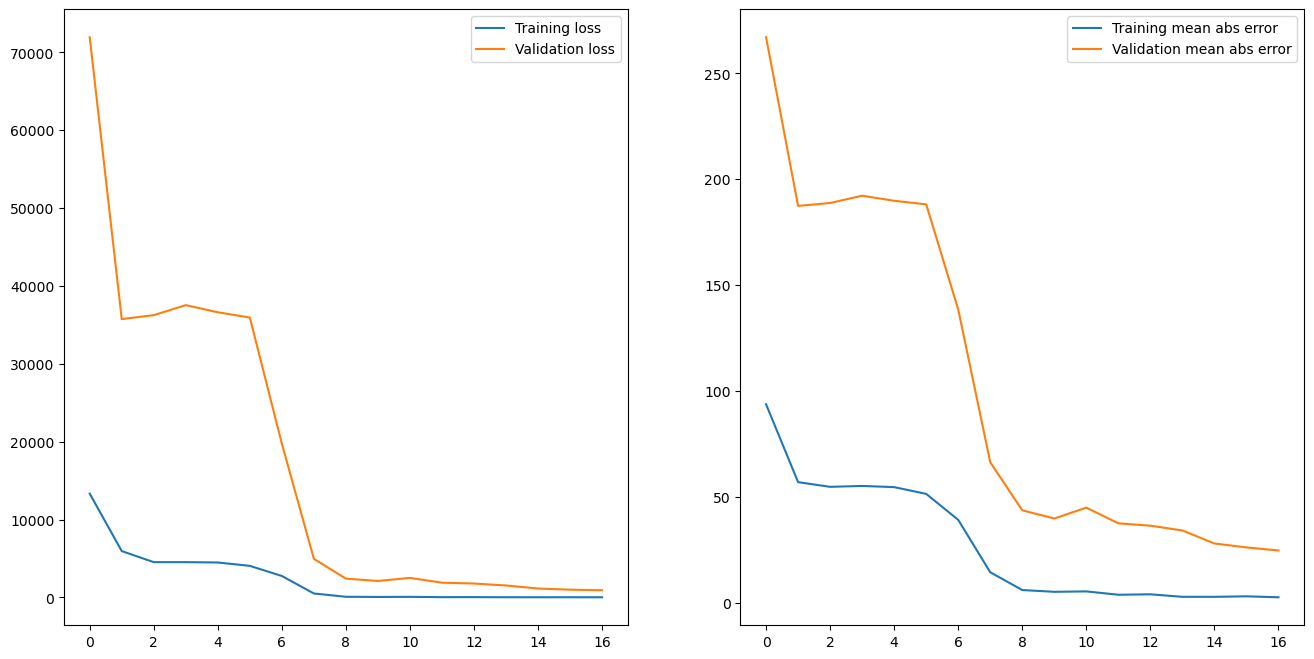

In [137]:
fix, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], label='Training loss')
ax[0].plot(history.history['val_loss'], label = 'Validation loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'Training mean abs error')
ax[1].plot(history.history['val_mean_absolute_error'], label='Validation mean abs error')
ax[0].legend()
ax[1].legend();

61/61 [==============================] - 2s 23ms/step
1923
1923


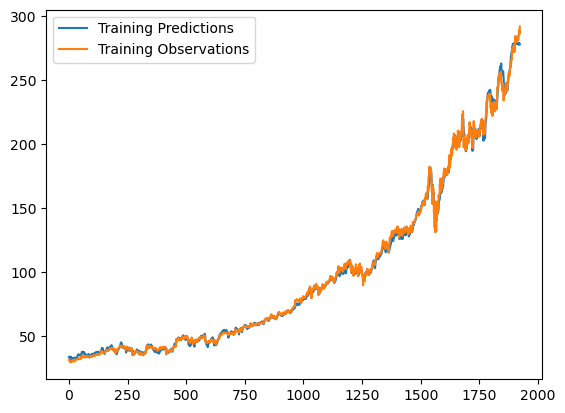

In [138]:
train_predictions = model.predict(train[predictors]).flatten()
print(len(train_predictions))
print(len(train[target]))
plt.plot(train_predictions)
plt.plot(np.array(train[target]))
plt.legend(['Training Predictions', 'Training Observations'])

8/8 [==============================] - 0s 25ms/step


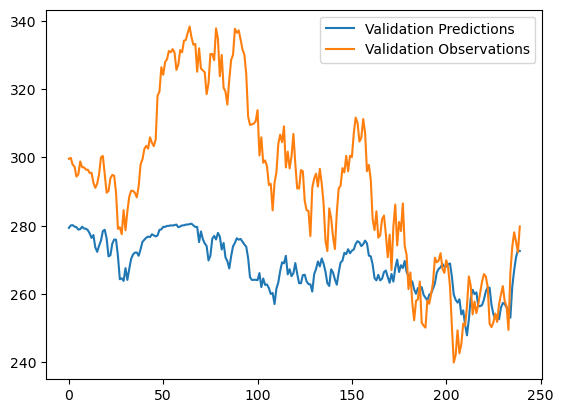

In [139]:
val_predictions = model.predict(val[predictors]).flatten()

plt.plot(val_predictions)
plt.plot(np.array(val[target]))
plt.legend(['Validation Predictions', 'Validation Observations'])

8/8 [==============================] - 0s 23ms/step


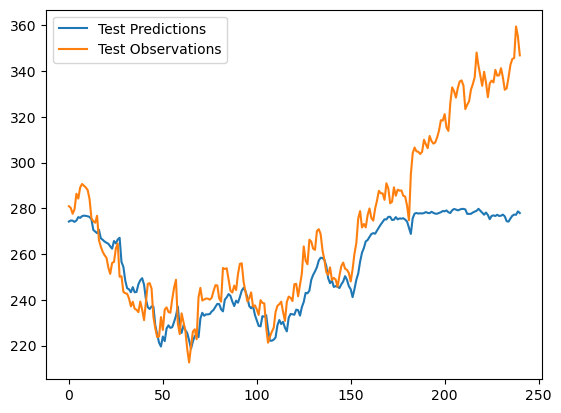

In [140]:
test_predictions = model.predict(test[predictors]).flatten()

plt.plot(test_predictions)
plt.plot(np.array(test[target]))
plt.legend(['Test Predictions', 'Test Observations'])

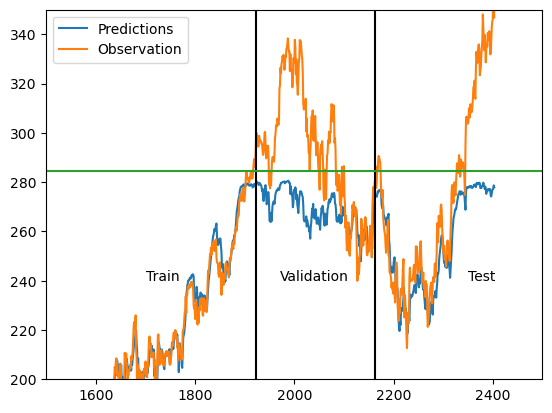

In [141]:
conc_preds = np.concatenate((train_predictions, val_predictions, test_predictions))
conc_obs = np.concatenate((train[target], val[target], test[target]))

plt.plot(conc_preds, label = 'Predictions')
plt.plot(conc_obs, label = 'Observation')

plt.plot((len(train_predictions), len(train_predictions)),(0, max(conc_obs)), color = 'k')
plt.plot((len(train_predictions)+len(val_predictions), len(train_predictions)+len(val_predictions)),(0, max(conc_obs)), color = 'k')


plt.legend(['Predictions', 'Observations'])
plt.text(1700, 240, 'Train', ha='left', wrap=True);
plt.text(1970, 240, 'Validation', ha='left', wrap=True);
plt.text(2350, 240, 'Test', ha='left', wrap=True);

#rsi_ema_10_1 = np.concatenate((train['rsi_ema_10_1'], val['rsi_ema_10_1'], test['rsi_ema_10_1']))
plt.plot((0,2500),(max(train['Close_1']),max(train['Close_1'])))
#plt.plot(np.array(df['SMA10_1']), label = 'SMA10')

plt.xlim(1500,2500)
plt.ylim(200,350)
plt.legend()
plt.show()

Observations:  
Price cannot be predicted higher than the maximum observed price within the train set  
Predictions were performed on a NoN-normalised dataset, normally all datasets for NN should be normalised

### Attempt to predict higher closing prices than observed in training set

For that we rescale Closing prices to a factors higher than maximum observed one. We are still working with a non normalised dataset - primarily for the sake of curiosity

In [142]:
norm_factor = 999
norm_close = df.copy(deep=True)
norm_close['next_day_Close'] = norm_close['next_day_Close']/norm_factor
norm_close['Close_1'] = norm_close['Close_1']/norm_factor
norm_close['Close_2'] = norm_close['Close_2']/norm_factor
norm_close['Close_3'] = norm_close['Close_3']/norm_factor
norm_close['Close_4'] = norm_close['Close_4']/norm_factor
norm_close['Close_5'] = norm_close['Close_5']/norm_factor

In [143]:
from sklearn.metrics import precision_score

predictors = [(x+'_'+str(y+1)) for y in range(0,window_width) for x in principal_predictors]

target = 'next_day_Close'
pred_score = 0

in_df = norm_close

q80 = int(in_df.shape[0]*0.8)
q90 = int(in_df.shape[0]*0.9) 
train = in_df.iloc[:q80]
val = in_df.iloc[q80:q90]
test = in_df.iloc[q90:]

es = EarlyStopping(monitor='mean_absolute_error', mode='min', verbose=1, patience=5, min_delta = 2)

model = compile_nn(predictors)
history = model.fit(np.array(train[predictors]), np.array(train[target])
                    ,validation_data=(val[predictors], val[target])
                    ,epochs=50
                    ,callbacks = [es]
                   )

Epoch 1/50
61/61 [==============================] - 8s 82ms/step - loss: 0.0113 - mean_absolute_error: 0.0725 - val_loss: 0.0452 - val_mean_absolute_error: 0.2118
Epoch 2/50
61/61 [==============================] - 5s 80ms/step - loss: 0.0013 - mean_absolute_error: 0.0265 - val_loss: 0.0128 - val_mean_absolute_error: 0.1115
Epoch 3/50
61/61 [==============================] - 4s 74ms/step - loss: 2.2856e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0035 - val_mean_absolute_error: 0.0564
Epoch 4/50
61/61 [==============================] - 4s 71ms/step - loss: 4.6247e-05 - mean_absolute_error: 0.0051 - val_loss: 0.0012 - val_mean_absolute_error: 0.0301
Epoch 5/50
61/61 [==============================] - 4s 71ms/step - loss: 2.8549e-05 - mean_absolute_error: 0.0041 - val_loss: 5.0388e-04 - val_mean_absolute_error: 0.0163
Epoch 6/50
61/61 [==============================] - 4s 68ms/step - loss: 7.3159e-05 - mean_absolute_error: 0.0069 - val_loss: 7.3890e-04 - val_mean_absolute_error: 0.022

In [144]:
train_predictions_norm = model.predict(train[predictors]).flatten()
val_predictions_norm = model.predict(val[predictors]).flatten()
test_predictions_norm = model.predict(test[predictors]).flatten()

8/8 [==============================] - 0s 36ms/step


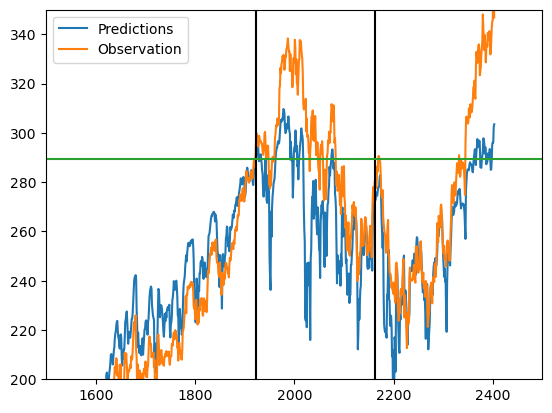

In [145]:
conc_preds_c_norm = np.concatenate((train_predictions_norm, val_predictions_norm, test_predictions_norm))
conc_obs_c_norm = np.concatenate((train[target], val[target], test[target]))

plt.plot(conc_preds_c_norm*norm_factor, label = 'Predictions')
plt.plot(conc_obs_c_norm*norm_factor, label = 'Observation')

plt.plot((len(train_predictions), len(train_predictions)),(0, max(conc_obs_c_norm)*norm_factor), color = 'k')
plt.plot((len(train_predictions)+len(val_predictions), len(train_predictions)+len(val_predictions)),(0, max(conc_obs_c_norm)*norm_factor), color = 'k')

plt.xlim(1500,2500)
plt.ylim(200,350)
plt.legend(['Predictions', 'Observations'])


#rsi_ema_10_1 = np.concatenate((train['rsi_ema_10_1'], val['rsi_ema_10_1'], test['rsi_ema_10_1']))
plt.plot((0,2500),(max(train['Close_5']*norm_factor),max(train['Close_5']*norm_factor)))
#plt.plot(np.array(df['SMA10_1']), label = 'SMA10')

plt.legend()
plt.show()

Price rescaling did not help

## Convert the predicted price to indicator if price increased

In [146]:
df_w_price_pred = df.copy(deep=True)
df_w_price_pred['next_day_Close_prediction'] = conc_preds
df_w_price_pred['next_day_Close_prediction_norm'] = conc_preds_c_norm * norm_factor

df_w_price_pred['next_day_Change_predictions'] = df_w_price_pred.apply(lambda x : 1 if x['next_day_Close_prediction'] >= x['Close_5'] else 0, axis=1)
df_w_price_pred['next_day_Change_predictions_norm'] = df_w_price_pred.apply(lambda x : 1 if x['next_day_Close_prediction_norm'] >= x['Close_5'] else 0, axis=1)

df_w_price_pred[['Close_5','next_day_Close_prediction','next_day_Change_predictions']].tail()

,Close_5,next_day_Close_prediction,next_day_Change_predictions
2023-07-07 00:00:00-04:00,342.660004,276.758362,0
2023-07-10 00:00:00-04:00,345.239990,277.272064,0
2023-07-11 00:00:00-04:00,345.730011,277.202484,0
2023-07-12 00:00:00-04:00,359.489990,278.692444,0
2023-07-13 00:00:00-04:00,355.079987,277.963593,0


In [147]:
df_w_price_pred['next_day_Change_predictions'].value_counts()

0    1493
1     911
Name: next_day_Change_predictions, dtype: int64

In [148]:
df_w_price_pred['next_day_Change_predictions_norm'].value_counts()

1    1353
0    1051
Name: next_day_Change_predictions_norm, dtype: int64

In [149]:
df_w_price_pred['next_day_Change'].value_counts()

1.0    1273
0.0    1131
Name: next_day_Change, dtype: int64

Next day change indicators derived from closing price predictions seems to have a more balanced distribution when dealing with rescaled Closing prices

In [150]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
recall = recall_score(df_w_price_pred['next_day_Change'], df_w_price_pred['next_day_Change_predictions'])
precision = precision_score(df_w_price_pred['next_day_Change'], df_w_price_pred['next_day_Change_predictions'])
accuracy = accuracy_score(df_w_price_pred['next_day_Change'], df_w_price_pred['next_day_Change_predictions'])
f1 = f1_score(df_w_price_pred['next_day_Change'], df_w_price_pred['next_day_Change_predictions'])
print('Non Rescaled closing prices')
print(f'Recall: {recall} \nPrecision: {precision} \nAccuracy: {accuracy} \nF1: {f1}')

Non Rescaled closing prices
Recall: 0.3857030636292223 
Precision: 0.5389681668496158 
Accuracy: 0.5 
F1: 0.44963369963369965


In [151]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
recall = recall_score(df_w_price_pred['next_day_Change'], df_w_price_pred['next_day_Change_predictions_norm'])
precision = precision_score(df_w_price_pred['next_day_Change'], df_w_price_pred['next_day_Change_predictions_norm'])
accuracy = accuracy_score(df_w_price_pred['next_day_Change'], df_w_price_pred['next_day_Change_predictions_norm'])
f1 = f1_score(df_w_price_pred['next_day_Change'], df_w_price_pred['next_day_Change_predictions_norm'])
print('Rescaled closing prices')
print(f'Recall: {recall} \nPrecision: {precision} \nAccuracy: {accuracy} \nF1: {f1}')

Rescaled closing prices
Recall: 0.5734485467399842 
Precision: 0.5395417590539542 
Accuracy: 0.5149750415973378 
F1: 0.5559786747905558


Recall: how many true possitive predictions were actually possitive TP/(TP+FN)  
Precision: how many positive predictions were REALLY possitive TP/(TP+FP)  
Accuracy: number of correct prediction/ number of all predictions (TP+TN)/all  

High recall: more likely to mark negative results as possitive  
                when price was going down we indicated that it will go up  
High precision: more likely to mark possitive result as negative  

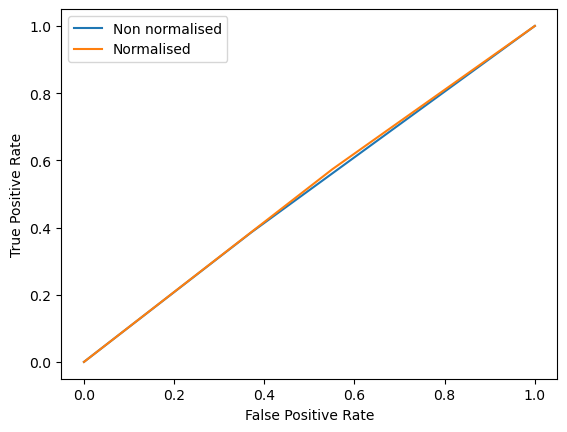

In [152]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(df_w_price_pred['next_day_Change'], df_w_price_pred['next_day_Change_predictions'])
fprn, tprn, _ = roc_curve(df_w_price_pred['next_day_Change'], df_w_price_pred['next_day_Change_predictions_norm'])

#create ROC curve
plt.plot(fpr,tpr, label = 'Non normalised')
plt.plot(fprn,tprn, label = 'Normalised')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

The ROC curve shows that predictions on the non normalised Closing prices acted as a Slightly better  classifier.  
Important note: only the closing prices were rescaled the rest of the dataframe remained non-normalised!

<Axes: >

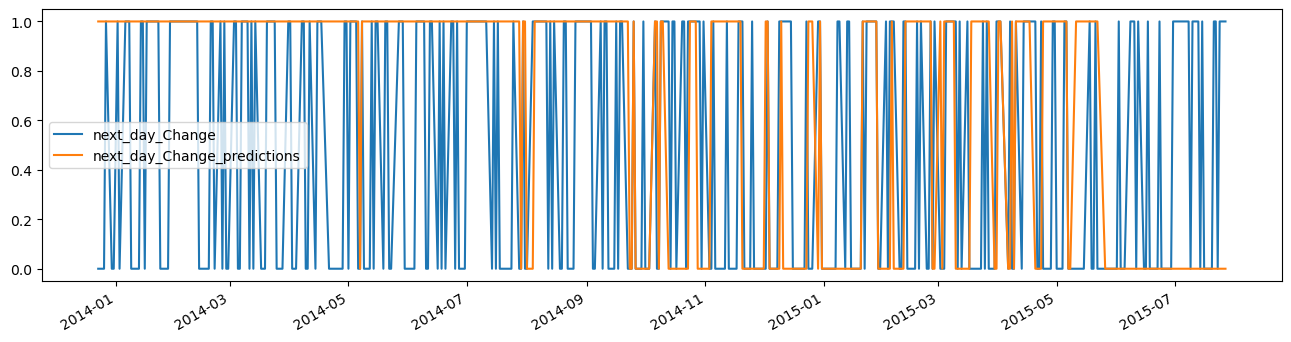

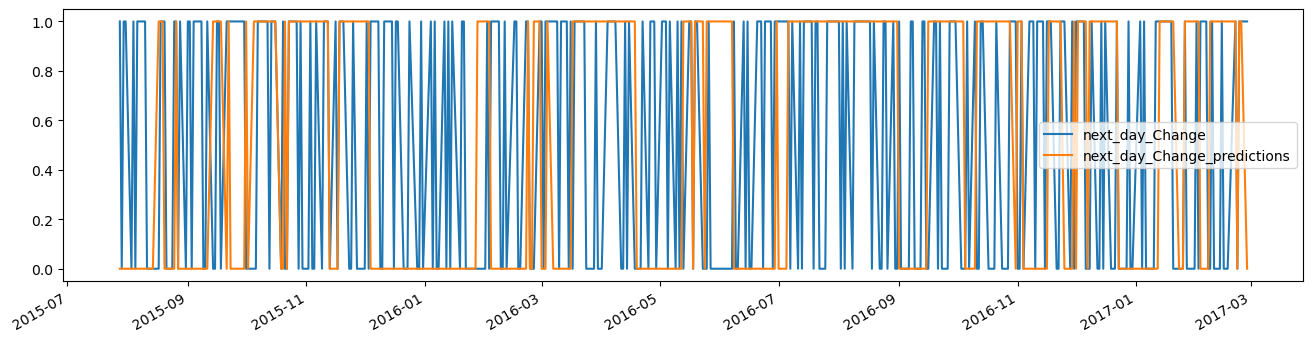

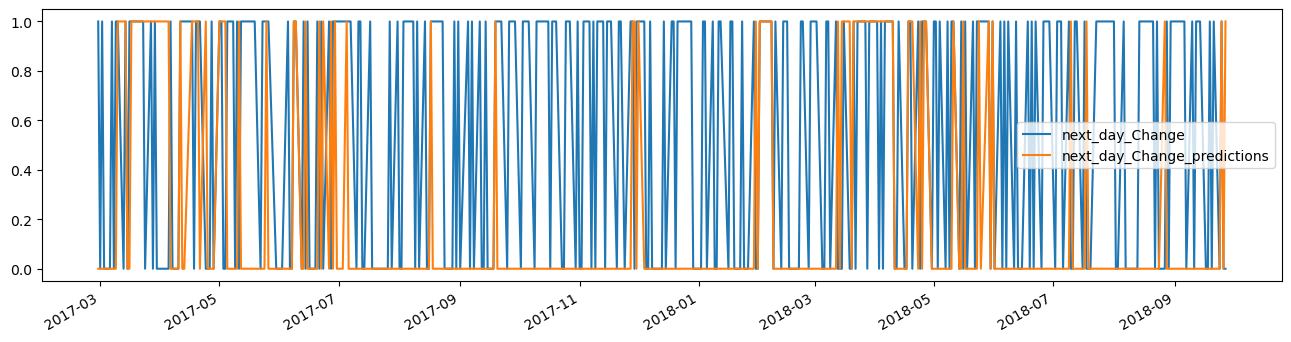

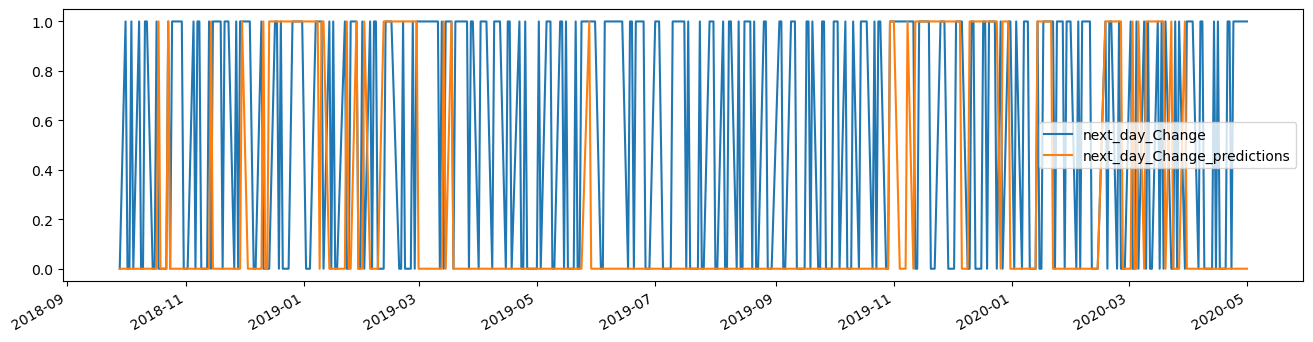

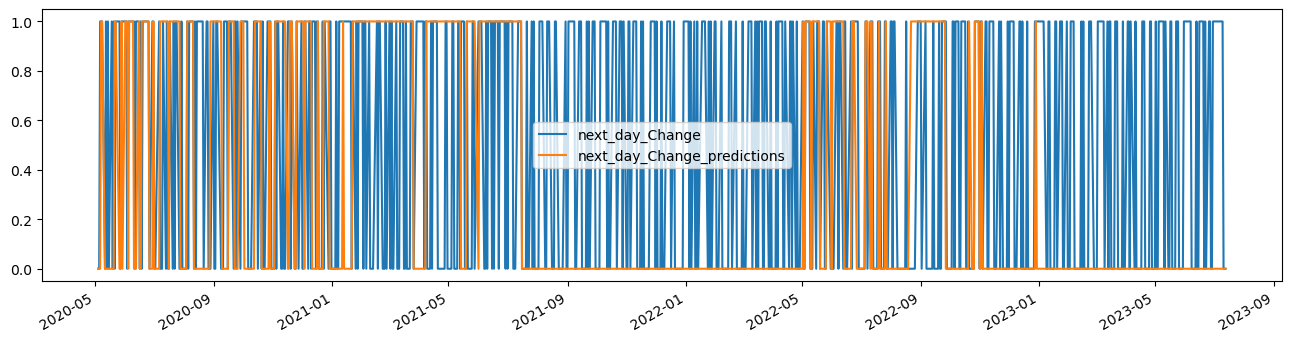

In [153]:
df_w_price_pred.iloc[:400].plot(y=['next_day_Change','next_day_Change_predictions'],figsize=(16,4))
df_w_price_pred.iloc[400:800].plot(y=['next_day_Change','next_day_Change_predictions'],figsize=(16,4))
df_w_price_pred.iloc[800:1200].plot(y=['next_day_Change','next_day_Change_predictions'],figsize=(16,4))
df_w_price_pred.iloc[1200:1600].plot(y=['next_day_Change','next_day_Change_predictions'],figsize=(16,4))
df_w_price_pred.iloc[1600:].plot(y=['next_day_Change','next_day_Change_predictions'],figsize=(16,4))

# Dimensionality reduction

## Use PCA for dimensionality reduction

Will PCA for dimensionality reduction provide better results than Forward Feature Selection

In [154]:
from sklearn.decomposition import PCA
PCA = PCA(n_components=5)
principalComponents_data = PCA.fit_transform(normalized_df)

pca_df = pd.DataFrame(data = principalComponents_data
        , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5']
        , index = normalized_df.index)


In [155]:
pca_df['next_day_Change'] = df['next_day_Change'].copy(deep=True)
pca_df['next_day_Close'] = df['next_day_Close'].copy(deep=True)

In [157]:
pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,next_day_Change,next_day_Close
2013-12-23 00:00:00-05:00,-104.597837,1.666990,-1.147474,-1.638865,-0.821993,0.0,31.632107
2013-12-24 00:00:00-05:00,-104.808286,0.875709,-0.733441,-0.748822,0.222663,0.0,31.420710
2013-12-26 00:00:00-05:00,-105.019856,0.987314,-0.949879,0.094864,0.160186,0.0,31.209324
2013-12-27 00:00:00-05:00,-105.679179,1.786293,-1.505459,0.957703,0.424894,1.0,30.549793
2013-12-30 00:00:00-05:00,-105.445499,2.989180,-2.405198,2.456318,1.919114,0.0,30.786549


Ok, lets try to predict next day price change using the PCA's

In [158]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf

def compile_nn_model(features):
    nr_inputs = len(features)
    model = Sequential([layers.Input((nr_inputs, 1)),
                        layers.LSTM(64), 
                        layers.Dense(32, activation='relu'),
                        layers.Dense(32, activation='relu'),
                        layers.Dense(1)])

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-4,
        decay_steps=100,
        decay_rate=0.9)

    optimiser = Adam(learning_rate = lr_schedule)

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    #we use Binary as loss function,because we are working with 2 classes
                    optimizer = optimiser,#tf.keras.optimizers.SGD(learning_rate=0.1), #lr 0.01 for normal df and 20 epochs
    #SGD stands for Stochastic Gradient Descent
                    metrics = ['accuracy'])
    return model

In [160]:
#Lets see if we can predict whether tomorrow closing price will be higher (1) or lower(0) than previous day
from sklearn.metrics import precision_score
from keras.callbacks import EarlyStopping

target = 'next_day_Change'

in_df = pca_df 

q80 = int(in_df.shape[0]*0.8) 
q90 = int(in_df.shape[0]*0.9) 
train = in_df.iloc[:q80]
val = in_df.iloc[q80:q90]
test = in_df.iloc[q90:]

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta = 0.05)

predictors = list(pca_df.columns)[:-2]

model = compile_nn_model(predictors)
history = model.fit(np.array(train[predictors]), np.array(train[target])
        ,validation_data=(val[predictors], val[target])
        ,batch_size= 32
        ,epochs=50
        ,callbacks = [es]
         )

Epoch 1/50
61/61 [==============================] - 4s 17ms/step - loss: 0.6976 - accuracy: 0.4607 - val_loss: 0.6929 - val_accuracy: 0.4958
Epoch 2/50
61/61 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.4607 - val_loss: 0.6936 - val_accuracy: 0.4958
Epoch 3/50
61/61 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.4607 - val_loss: 0.6941 - val_accuracy: 0.4958
Epoch 4/50
61/61 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.4607 - val_loss: 0.6945 - val_accuracy: 0.4958
Epoch 5/50
61/61 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.4607 - val_loss: 0.6947 - val_accuracy: 0.4958
Epoch 6/50
61/61 [==============================] - 0s 6ms/step - loss: 0.6898 - accuracy: 0.4607 - val_loss: 0.6946 - val_accuracy: 0.4958
Epoch 6: early stopping


In [161]:
train_predictions = model.predict(train[predictors]).flatten()
val_predictions = model.predict(val[predictors]).flatten()
test_predictions = model.predict(test[predictors]).flatten()

8/8 [==============================] - 0s 3ms/step


In [162]:
train[target].value_counts()

1.0    1037
0.0     886
Name: next_day_Change, dtype: int64

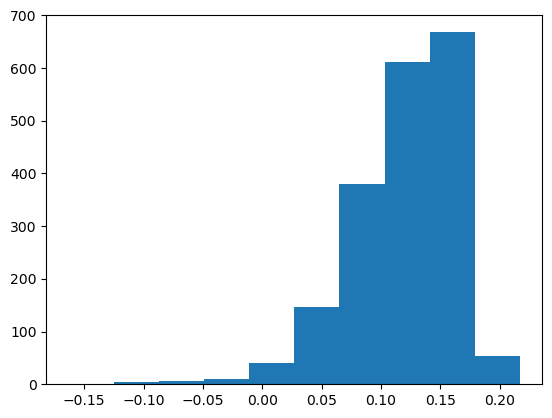

In [163]:
plt.hist(train_predictions);

In [164]:
train_prediction_round = np.round(train_predictions)

In [165]:
unique, counts = np.unique(train_prediction_round, return_counts=True)
dict(zip(unique, counts))

{0.0: 1923}

In [166]:
train[target].value_counts()

1.0    1037
0.0     886
Name: next_day_Change, dtype: int64

So all the predictions are the same, therefore showing no improvement in the results.
We can still have a look how that reflects to the metrics

In [167]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
recall = recall_score(np.array(train[target]), train_prediction_round)
precision = precision_score(np.array(train[target]), train_prediction_round)
accuracy = accuracy_score(np.array(train[target]), train_prediction_round)
f1 = f1_score(np.array(train[target]), train_prediction_round)
print(f'Recall: {recall} \nPrecision: {precision} \nAccuracy: {accuracy} \nF1: {f1}')

Recall: 0.0 
Precision: 0.0 
Accuracy: 0.46073842953718147 
F1: 0.0


C:\Users\arvyd\.conda\envs\DS-Sample\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As expected zero division does not work and math still functions.

As a reminder:  
Recall: how many true possitive were actually possitive TP/(TP+FN)  
Precision: how many positive predictions were REALLY possitive TP/(TP+FP)  
Accuracy: number of correct prediction/ number of all predictions (TP+TN)/all  

High recall: more likely to mark negative results as possitive  
                when price was going down we indicated that it will go up  
High precision: more likely to mark possitive result as negative  

## Attempt to predict the Closing price instead using the PCA

In [168]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf

def compile_nn(predictors):
    nr_inputs = len(predictors)
    model = Sequential([layers.Input((nr_inputs, 1)),
                        layers.LSTM(64), #LSTM
                        layers.Dense(32, activation='relu'),
                        layers.Dense(32, activation='relu'),
                        layers.Dense(1)])

    model.compile(loss = 'mse',
                    optimizer = Adam(learning_rate=0.001), 
                    metrics = ['mean_absolute_error'])
    model.summary()
    return model

In [170]:
from sklearn.metrics import precision_score

predictors = list(pca_df.columns)[:-2]
target = 'next_day_Close'

in_df = pca_df

q80 = int(in_df.shape[0]*0.8)
q90 = int(in_df.shape[0]*0.9) 
train = in_df.iloc[:q80]
val = in_df.iloc[q80:q90]
test = in_df.iloc[q90:]

model= compile_nn(predictors)

es = EarlyStopping(monitor='mean_absolute_error', mode='min', verbose=1, patience=5, min_delta = 2)

history = model.fit(np.array(train[predictors]), np.array(train[target])
          ,validation_data=(val[predictors], val[target])
          ,epochs=50
          ,callbacks = [es]
         )

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 64)                16896     
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dense_33 (Dense)            (None, 32)                1056      
                                                                 
 dense_34 (Dense)            (None, 1)                 33        
                                                                 
Total params: 20,065
Trainable params: 20,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
61/61 [==============================] - 3s 16ms/step - loss: 13024.7090 - mean_absolute_error: 91.7675 - val_loss: 66377.1484 - val_mean_absolute_error: 256.5733
Epoch 2

In [172]:
train_predictions = model.predict(train[predictors]).flatten()
val_predictions = model.predict(val[predictors]).flatten()
test_predictions = model.predict(test[predictors]).flatten()

8/8 [==============================] - 0s 3ms/step


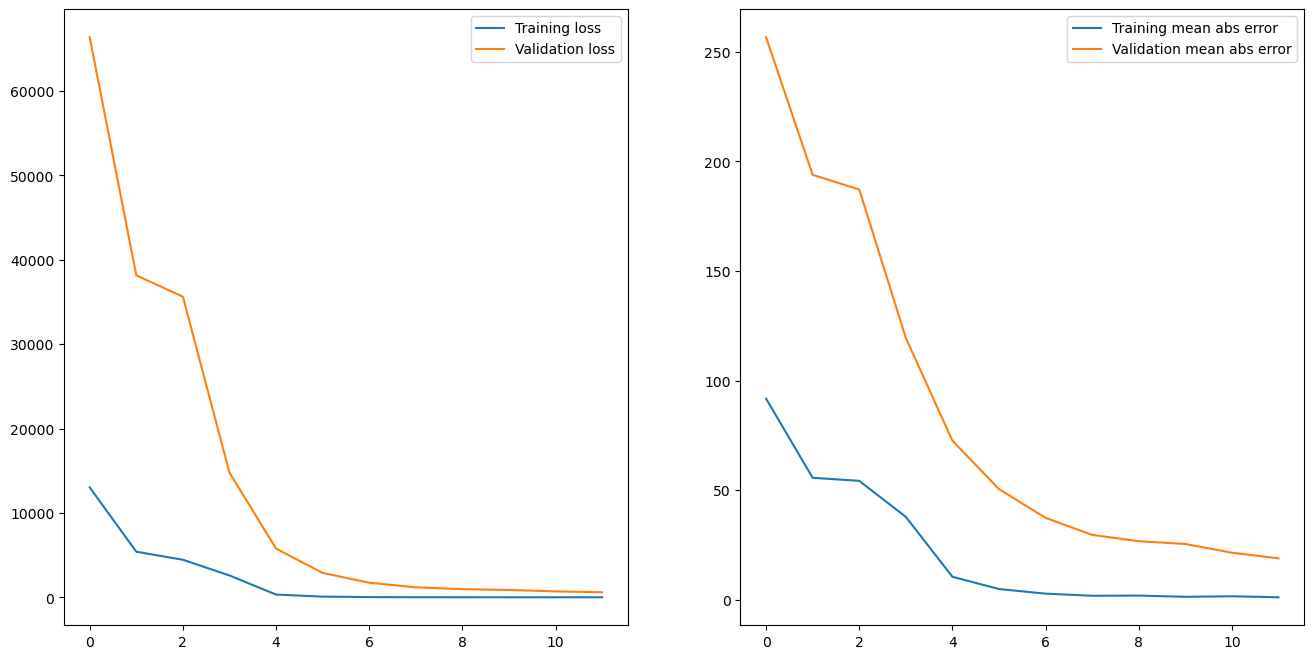

In [173]:
fix, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], label='Training loss')
ax[0].plot(history.history['val_loss'], label = 'Validation loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'Training mean abs error')
ax[1].plot(history.history['val_mean_absolute_error'], label='Validation mean abs error')
ax[0].legend()
ax[1].legend();

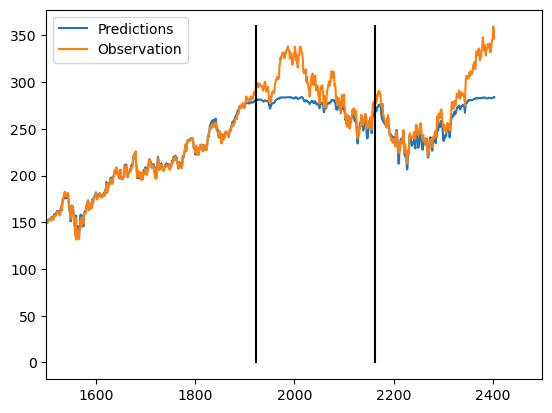

In [174]:
conc_preds = np.concatenate((train_predictions, val_predictions, test_predictions))
conc_obs = np.concatenate((train[target], val[target], test[target]))

plt.plot(conc_preds, label = 'Predictions')
plt.plot(conc_obs, label = 'Observation')

plt.plot((len(train_predictions), len(train_predictions)),(0, max(conc_obs)), color = 'k')
plt.plot((len(train_predictions)+len(val_predictions), len(train_predictions)+len(val_predictions)),(0, max(conc_obs)), color = 'k')

plt.xlim(1500,2500)
plt.legend(['Predictions', 'Observations'])


#rsi_ema_10_1 = np.concatenate((train['rsi_ema_10_1'], val['rsi_ema_10_1'], test['rsi_ema_10_1']))
#plt.plot((0,2500),(max(train['Close_1']),max(train['Close_1'])))
#plt.plot(np.array(df['SMA10_1']), label = 'SMA10')

plt.legend()
plt.show()

In [175]:
pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,next_day_Change,next_day_Close
2013-12-23 00:00:00-05:00,-104.597837,1.666990,-1.147474,-1.638865,-0.821993,0.0,31.632107
2013-12-24 00:00:00-05:00,-104.808286,0.875709,-0.733441,-0.748822,0.222663,0.0,31.420710
2013-12-26 00:00:00-05:00,-105.019856,0.987314,-0.949879,0.094864,0.160186,0.0,31.209324
2013-12-27 00:00:00-05:00,-105.679179,1.786293,-1.505459,0.957703,0.424894,1.0,30.549793
2013-12-30 00:00:00-05:00,-105.445499,2.989180,-2.405198,2.456318,1.919114,0.0,30.786549


So it seems my models were more succesfull predicting tomorrows price rather than indicator that the price will increase or decrease.   Additionally, dimension reduction did not provide any benefit